CODING PROJECT-2(COVID-19)

SUMANTA CHANDRA MISHRA SHARMA


In [0]:
# Mount Drive..............................................................................................................................
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Import Packages..........................................................................................................................

import cv2
import glob
import torch
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as Scheduler
from time import time
from torch.utils import data
from torchvision import models
from torchsummary import summary
from google.colab.patches import cv2_imshow
from sklearn.model_selection  import train_test_split 


In [0]:

#Loading and Extracting the dataset......................................................................................................... 

Dataset = [filename for filename in glob.glob("/content/drive/My Drive/Source1/*")]
Dataset.extend([filename for filename in glob.glob("/content/drive/My Drive/Source2/*")])
Dataset.extend([filename for filename in glob.glob("/content/drive/My Drive/Source5/*")])
Dataset.extend([filename for filename in glob.glob("/content/drive/My Drive/Source6/*")])
Dataset.extend([filename for filename in glob.glob("/content/drive/My Drive/Source7/*")])

image_list=[]
for filename in Dataset:
    im=cv2.imread(filename)
    im=cv2.resize(im,(224,224),interpolation=cv2.INTER_NEAREST)
    im=torch.tensor(im, dtype=torch.float) / 255.0 
    image_name = filename.split('/')[5]
    image_list.append((image_name, im))


In [0]:
# Training and Testing Label................................................................................................................ 

TR_label=pd.read_csv('/content/drive/My Drive/Train_Combined.csv')
Label=TR_label.where(TR_label['Data Source'].str.contains('|'.join(('Source-1','Source-2','Source-5','Source-6','Source-7'))))
Label.reset_index(inplace=True,drop=True)
Label.dropna(inplace=True)
TR_label=Label

TS_label=pd.read_csv('/content/drive/My Drive/Test_Combined.csv')
Label=TS_label.where(TS_label['Data Source'].str.contains('|'.join(('Source-1','Source-2','Source-5','Source-6','Source-7'))))
Label.reset_index(inplace=True,drop=True)
Label.dropna(inplace=True)
TS_label=Label

In [0]:
#Model......................................................................................................................................
TR_GPU=0
def get_pretrained_model(model_name):
    
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        model_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(nn.Linear(model_inputs, 512), nn.ReLU(), nn.Dropout(0.2),
                                            nn.Linear(512, 64), nn.ReLU(), nn.Dropout(0.2),
                                            nn.Linear(64, 3), nn.LogSoftmax(dim=1))

    # Move to gpu
    if TR_GPU:
        model = model.to('cuda')
    return model

In [0]:
# The model summary and complexity........................................................................................................ 

model = get_pretrained_model('vgg16')
summary(model, input_size=(3, 224, 224), batch_size=1)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256

In [0]:
#Training and Validating.....................................................................................................................

count=0
epochs = 30
run_loss_val = 0
previous_run_loss_val=0
train_loss=[]
val_loss=[]
val_acc=[]
max_patience_count=5
time0 = time()
optimizer = optim.Adam(model.parameters())

# ReduceLROnPlateau scheduler for hot restart
scheduler=Scheduler.ReduceLROnPlateau(optimizer,'min')
for e in range(epochs):
    previous_run_loss_val=run_loss_val
    run_loss_train = 0
    run_loss_val = 0
    pos_count=0

# Random Split of training and validation set from the training data in ratio 85:15.  
    train_label, val_label = train_test_split(TR_label, test_size=0.15,random_state=1)

    for i in train_label.index:
        labels=torch.from_numpy(np.expand_dims(np.array(train_label.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
        img_name=train_label.loc[i]['Image Name']
        
        for j in range(len(image_list)):
          if image_list[j][0]==img_name:
            img=image_list[j][1]
        
        img=np.transpose(img)
        images=torch.from_numpy(np.expand_dims(img,0))
        optimizer.zero_grad()
        
        output = model(images)
        criterion = nn.NLLLoss()
        loss =criterion(output, labels.argmax(dim=1))       
        loss.backward()
        optimizer.step()
        run_loss_train += loss.item()

    for i in val_label.index:
        labels=torch.from_numpy(np.expand_dims(np.array(val_label.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
        img_name=val_label.loc[i]['Image Name']
        
        for j in range(len(image_list)):
          if image_list[j][0]==img_name:
            img=image_list[j][1]
        
        img=np.transpose(img)
        images=torch.from_numpy(np.expand_dims(img,0))

        output = model(images)
        loss =criterion(output, labels.argmax(dim=1))
        MAX=np.argmax(output.detach().numpy())
        if int(np.argmax(labels))==MAX:
          pos_count +=1
        run_loss_val += loss.item()

    else:
# Stopping criteria (if there is no improvement in validation loss for last for 5 epochs then training stops)
        if abs(previous_run_loss_val/len(val_label)-run_loss_val/len(val_label))<=.0001:
          count =count+1
        else:
          count=0
        if count==max_patience_count:
          break;
# Scheduler step
        scheduler.step(previous_run_loss_val)

        train_loss.append(run_loss_train/len(train_label))
        val_loss.append(run_loss_val/len(val_label))
        val_acc.append(pos_count/len(val_label))
        print("Epoch {} - Training loss: {}, Validation loss: {}, validation accuracy: {}".format(e, run_loss_train/len(train_label),run_loss_val/len(val_label),pos_count/len(val_label)))



Epoch 0 - Training loss: 0.7499474239664804, Validation loss: 0.5105931987477974, validation accuracy: 0.7954545454545454
Epoch 1 - Training loss: 0.5318470529192353, Validation loss: 0.5306683105670593, validation accuracy: 0.8181818181818182
Epoch 2 - Training loss: 0.5692314846068433, Validation loss: 0.4519930893385952, validation accuracy: 0.8181818181818182
Epoch 3 - Training loss: 0.5435115619585568, Validation loss: 0.46190952780571853, validation accuracy: 0.8636363636363636
Epoch 4 - Training loss: 0.5025312809862483, Validation loss: 0.5051311167719011, validation accuracy: 0.8409090909090909
Epoch 5 - Training loss: 0.511646025075753, Validation loss: 0.4470490679483522, validation accuracy: 0.7954545454545454
Epoch 6 - Training loss: 0.43201424534497795, Validation loss: 0.5073618974519459, validation accuracy: 0.8181818181818182
Epoch 7 - Training loss: 0.4227554368579501, Validation loss: 0.5519140612979588, validation accuracy: 0.7727272727272727
Epoch 8 - Training loss

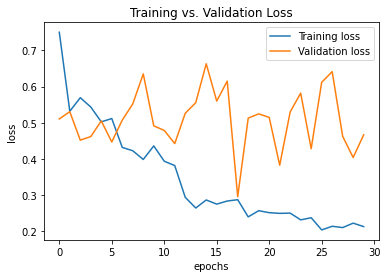

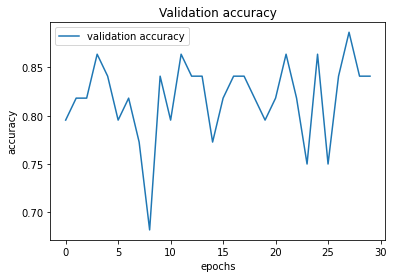


Training Time (in minutes) = 92.55441416104635


In [0]:
#Plotting ...................................................................................................................................
#Training and validation loss Plot
x1 = range(epochs)
y1 = train_loss
plt.plot(x1, y1, label = "Training loss")
x2 = range(epochs)
y2 = val_loss
plt.plot(x2, y2, label = "Validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()
#Validation Accuracy Plot
x1=range(epochs)
y1=val_acc
plt.plot(x1,y1,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.show()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [0]:
#Testing....................................................................................................................................

pos_count=0
for i in TS_label.index:
   
    labels=torch.from_numpy(np.expand_dims(np.array(TS_label.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
    img_name =TS_label.loc[i]['Image Name']
    
    for j in range(len(image_list)):
          if image_list[j][0]==img_name:
            img=image_list[j][1]
    if(img.shape[0]!=3):
      img=np.transpose(img)
    images=torch.from_numpy(np.expand_dims(img,0))
    output = model(images)
    MAX=np.argmax(output.detach().numpy())
    if int(np.argmax(labels))==MAX: 
      pos_count +=1
    
print('Testing accuracy is: {}'.format(pos_count/len(TS_label)*100))

Testing accuracy is: 76.92307692307693
